In [1]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Send
from langchain.chat_models import init_chat_model
from typing import TypedDict, Annotated
from openai import OpenAI
import operator
import subprocess
import textwrap
import base64

class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    final_summary: str
    thumbnail_prompts: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]

In [ ]:
def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]

    subprocess.run(command)
    return {"audio_file": output_file}


def transcribe_audio(state: State):
    # audio_file = state["audio_file"]
    client = OpenAI()
    with open(state["audio_file"], mode="rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="ko",
            prompt="Netherlands, Rotterdam, Amsterdam, The Hage",
        )
    return {
        "transcription": transcription,
    }


def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i + 1, "chunk": chunk})

    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):

    llm = init_chat_model("openai:gpt-4o-mini")
    summary = []

    chunk_id = chunk["id"]
    chunk = chunk["chunk"]

    prompt = f"""
    다음 청크를 요약해주세요.
    청크: {chunk}
    """
    response = llm.invoke(prompt)

    summary = f"[chunk {chunk_id}] {response.content}"
    return {
        "summaries": [summary],
    }

def mega_summary(state: State):
    summary = state["summaries"]

    prompt = f"""
    다음 요약본은 영상 스크립트를 여러 청크로 나누고 각 청크를 요약한 것입니다.

    요약본을 모든 키워드를 아우를 수 있는 최종 요약본으로 만들어주세요.

    요약본: {summary}
    """
    llm = init_chat_model("openai:gpt-4o-mini")

    response = llm.invoke(prompt)

    return {
        "final_summary": response.content,
    }


def dispatch_artists(state: State):
    final_summary = state["final_summary"]
    return [Send("generate_thumbnails", arg={
        "id": i,
        "summary": final_summary
    }) for i in [1, 2, 3, 4]]

def generate_thumbnails(args):

    id = args["id"]
    summary = args["summary"]

    prompt = f"""
    Based on this video summary, create a detailed visual prompt for a YouTube thumbnail.

    Create a detailed prompt for generating a thumbnail image that would attract viewers. Include:
        - Main visual elements
        - Color scheme
        - Text overlay suggestions
        - Overall composition

    summary: {summary}
    """

    llm = init_chat_model("openai:gpt-4o-mini")

    response = llm.invoke(prompt) # 유튜브 프롬프트

    client = OpenAI()

    result = client.images.generate(
        prompt=response.content,
        model="gpt-image-1",
        quality="low",
        moderation='low',
        size='auto'
    )

    image = base64.b64decode(result.data[0].b64_json)

    file_path = f"thumbnail_{id}.jpg"

    with open(file_path, "wb") as file:
        file.write(image)

    return {
        "thumbnail_prompts": [response],
        "thumbnail_sketches": [file_path],
    }

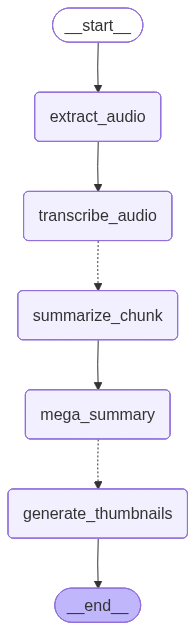

In [3]:
graph_builder = StateGraph(State)

graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("summarize_chunk", summarize_chunk)
graph_builder.add_node("mega_summary", mega_summary)
graph_builder.add_node("generate_thumbnails", generate_thumbnails)

graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges(
    "transcribe_audio", dispatch_summarizers, ["summarize_chunk"]
)
graph_builder.add_edge("summarize_chunk", "mega_summary")
graph_builder.add_conditional_edges(
    "mega_summary", dispatch_artists, ["generate_thumbnails"]
)
graph_builder.add_edge("generate_thumbnails", END)

graph = graph_builder.compile()
graph

In [4]:
graph.invoke(
    {
        "video_file": "./video.mp4"
    }
)

TypeError: can only concatenate list (not "AIMessage") to list